## Implemented from Andrej Karpathy's 'Building Micrograd'

In [1]:
import math
class Value:
    def __init__(self, data, _children = (), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"

    def __add__(self, other) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self+other

    def __mul__(self, other) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other) -> 'Value':
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __truediv__(self, other) -> 'Value':
        return self * other**-1

    def __neg__(self) -> 'Value':
        return self * -1
    
    def __sub__(self, other) -> 'Value':
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def relu(self) -> 'Value':
        out = Value(0 if self.data < 0 else self.data, (self, ), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad

        out._backward = _backward
        return out

    def tanh(self) -> 'Value':
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self) -> 'Value':
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self) -> None:
        
        topo=[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [2]:
from graphviz import Digraph

def trace(root):
    #builds a set of all the nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [3]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')

In [4]:
c = Value(10.0, label='c')
d = a*b; d.label = 'd'

In [5]:
e = d + c; e.label = 'e'

In [6]:
#f = e.tanh(); f.label = 'f'

In [7]:
x = (2*e).exp()
f = (x-1)/(x+1)

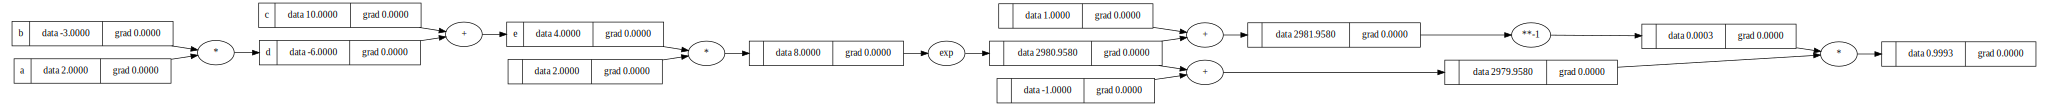

In [ ]:
draw_dot(f)

In [9]:
f.backward()

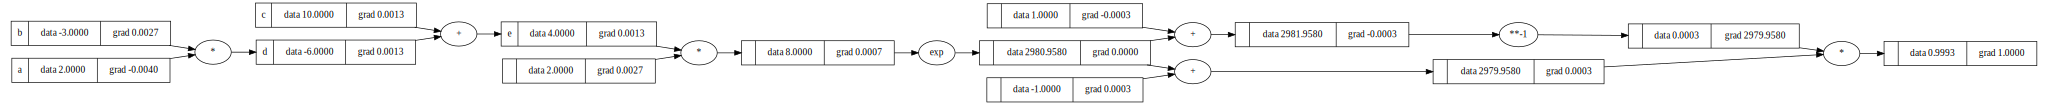

In [ ]:
draw_dot(f)

### Checking for bugs

In [11]:
# a = Value(3.0, label='a')
# b = a + a; b.label = 'b'
# b.backward()
# draw_dot(b)#.render('tmp/1', view=True)

In [12]:
# a = Value(-2.0, label='a')
# b = Value(3.0, label='b')
# d = a*b; d.label = 'd'
# e = a+b; e.label = 'e'
# f = d*e; f.label = 'f'
# f.backward()

# draw_dot(f)

### Checking the results with pytorch!

In [13]:
import torch

In [14]:
a = torch.Tensor([2.0]).double()                             ; a.requires_grad = True
b = torch.Tensor([-3.0]).double()                             ; b.requires_grad = True
c = torch.Tensor([10.0]).double()                            ; c.requires_grad = True
d = a*b                                                      ; d.retain_grad()
e = d + c                                                    ; e.retain_grad()
o = torch.tanh(e)                                            

print('o', o.data.item())
o.backward()
print("_____________")
print('a', a.grad.item())
print('b', b.grad.item())
print('c', c.grad.item())
print('d', d.grad.item())
print('e', e.grad.item())


o 0.999329299739067
_____________
a -0.004022852049077749
b 0.002681901366051833
c 0.0013409506830259165
d 0.0013409506830259165
e 0.0013409506830259165


### Creating MLP

In [15]:
import random
class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x) -> 'Value':
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [16]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data = 0.9896322199222028)

In [17]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params

In [18]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data = -0.9800795037733432),
 Value(data = 0.9970918627456232),
 Value(data = -0.21313749069624682)]

In [19]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [20]:
x = [2.0, -3.0, 1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data = 0.3340344735006666)

In [21]:
len(n.parameters())

41

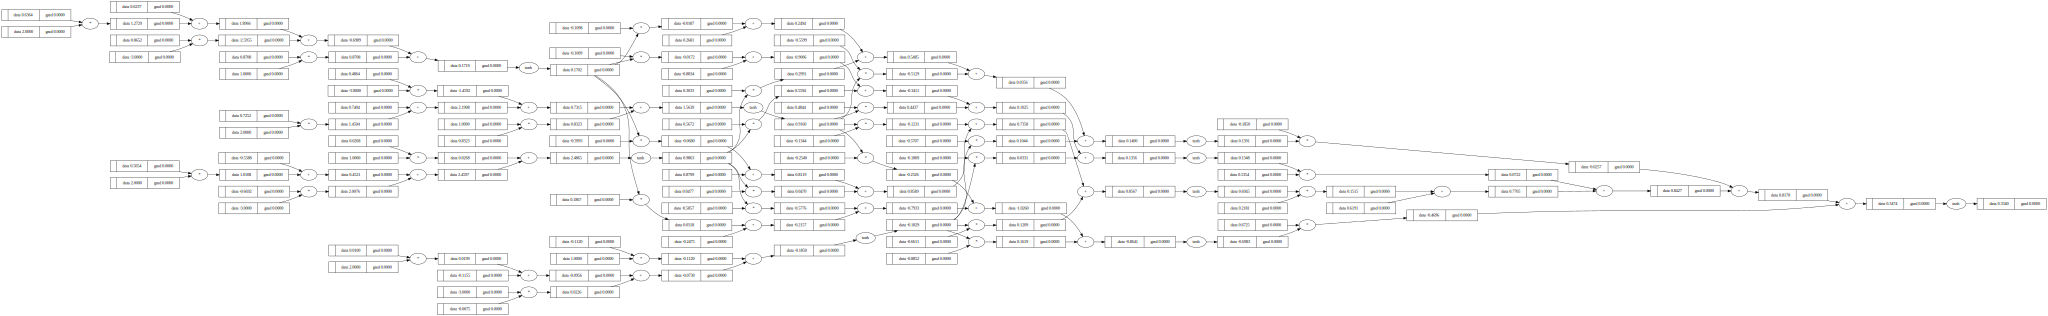

In [22]:
draw_dot(n(x))

In [23]:
xs = [
    [2.0, 3.0, -1.0],
    [3,0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [24]:
ypred = [n(x) for x in xs]
ypred

[Value(data = 0.4869642125663795),
 Value(data = 0.23967949226582708),
 Value(data = 0.5555469935396149),
 Value(data = 0.41620194411079064)]

In [25]:
n.layers[0].neurons[0].w[0].grad

0.0

In [26]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

In [27]:
loss

Value(data = 4.560557581902248)

In [28]:
loss.backward()

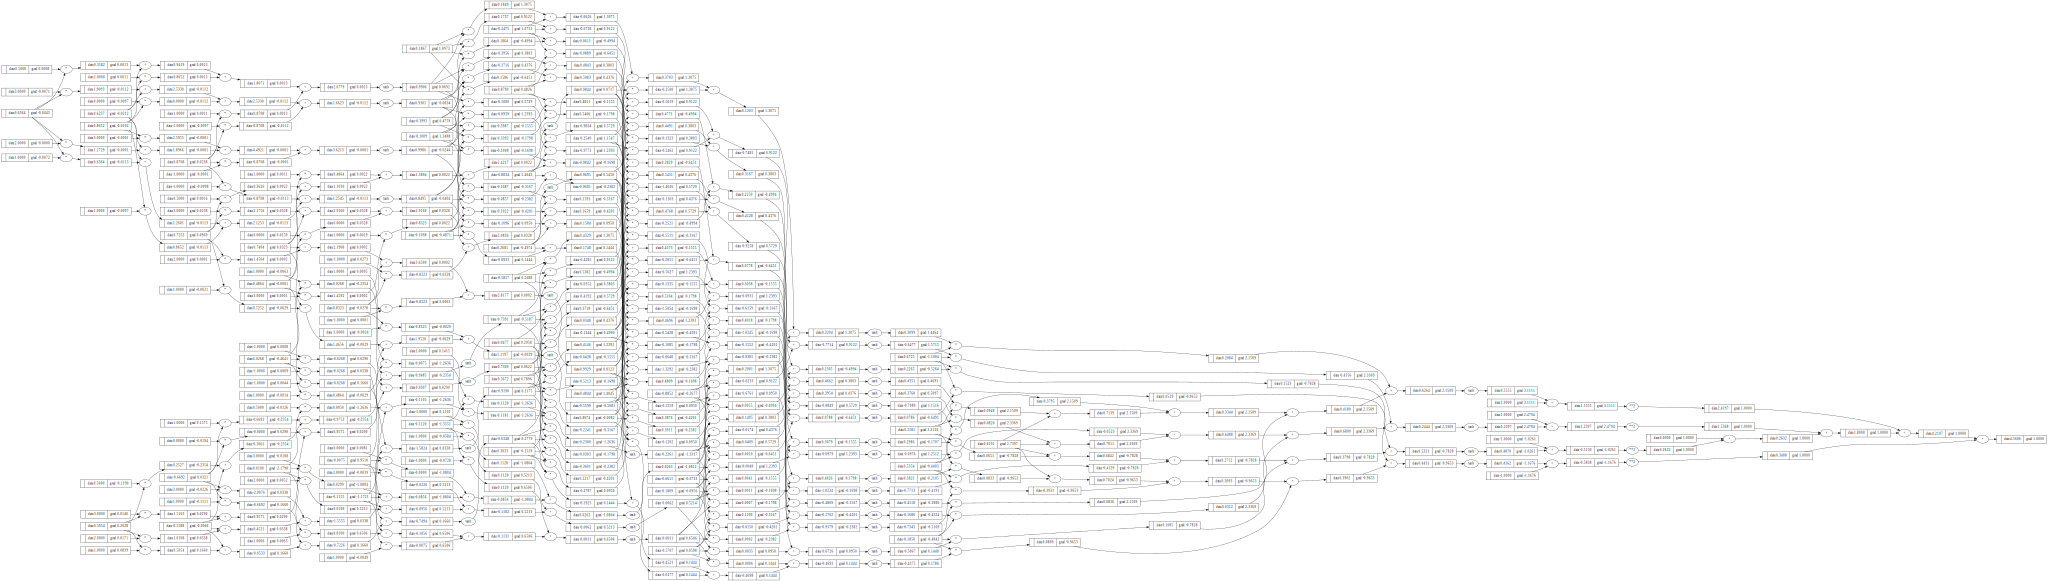

In [29]:
draw_dot(loss)

In [30]:
n.layers[0].neurons[0].w[0].grad

-0.04432132805816487

In [31]:
n.layers[0].neurons[0].w[0].data

0.6364442341345691

In [38]:
for k in range(200):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data -= 0.01 * p.grad

    print(k, loss.data)

0 0.004343360663477409
1 0.004338412448388402
2 0.004333475066809955
3 0.004328548483785106
4 0.004323632664505701
5 0.004318727574311613
6 0.004313833178689944
7 0.0043089494432742475
8 0.00430407633384376
9 0.004299213816322655
10 0.004294361856779258
11 0.004289520421425266
12 0.004284689476615069
13 0.004279868988844939
14 0.004275058924752313
15 0.004270259251115047
16 0.0042654699348507
17 0.004260690943015778
18 0.00425592224280499
19 0.00425116380155064
20 0.0042464155867217536
21 0.004241677565923528
22 0.0042369497068964704
23 0.004232231977515792
24 0.0042275243457907076
25 0.004222826779863695
26 0.0042181392480098836
27 0.004213461718636248
28 0.0042087941602810715
29 0.004204136541613123
30 0.004199488831431135
31 0.004194850998663024
32 0.004190223012365252
33 0.004185604841722174
34 0.0041809964560454126
35 0.004176397824773171
36 0.0041718089174695855
37 0.004167229703824087
38 0.004162660153650767
39 0.004158100236887707
40 0.004153549923596428
41 0.004149009183961221

In [39]:
ypred

[Value(data = 0.974665998328159),
 Value(data = -0.9727626870062605),
 Value(data = -0.9693209228774827),
 Value(data = 0.9652177692133053)]